# 🔧 Техническое задание: Анализ зависимости между продажами и ключевой ставкой ЦБ РФ

## 📌 Цель

Определить, существует ли зависимость между продажами компании и ключевой ставкой Центрального Банка РФ за 2024 год.

---

## 🗂️ Входные данные

### 1. Таблица с продажами по месяцам (`df_sales`)

Содержит значения выручки компании на каждый месяц.

💡 *Важно*: период с данными по продажам может меняться, скрипт должен быть гибким и не жёстко привязан к конкретному диапазону дат.

```python
dates = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS').strftime('%Y-%m-%d')

df_sales = pd.DataFrame({
    'date': dates,
    'sales': [5350, 5450, 5500, 4500, 4400, 3900, 3800, 4000, 4500, 4900, 5000, 5500]
})
```

### 2. Ключевая ставка ЦБ РФ
Исторические данные находятся на официальном сайте Банка России:
🔗 https://www.cbr.ru/hd_base/keyrate/

## 📌 **Задачи**
1. Собрать данные о ключевой ставке с сайта ЦБ РФ: подключиться к сайту с ключевой ставкой, спарсить актуальные данные сайта любым доступным способом.
2. Сгруппировать данные по максимальной ключевой ставке за месяц
3. Объединить таблицу продаж (df_sales) и сгруппированную таблицу с ключевой ставкой.
   В итоге должна получится таблица, состоящая из трех столбцов: date, sales, rate (ключевая ставка)
4. Сделать выводы: имеется ли зависимость между объемом продаж. Для этого можно использовать любой доступный способ (например, визуализация)


## 📈 **Ожидаемые результаты**
1. Ключевая ставка парсится каждый раз при запуске скрипта
2. Имеется итоговая таблица со столбцами date, sales, rate (ключевая ставка) с данными на каждый месяц, при изменении периода в df_sales, ключевая ставка также подтягивается в объединенную таблицу.
3. Сделаны выводы по зависимости объема продаж от ключевой ставки.

In [ ]:
# если не установлен parser lxml
#!pip install lxml 

In [9]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

import requests
from bs4 import BeautifulSoup


In [10]:
dates = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS').strftime('%Y-%m-%d')
df_sales = pd.DataFrame({
    'date': dates,
    'sales': [5350, 5450, 5500, 4500, 4400, 3900, 3800, 4000, 4500, 4900, 5000, 5500]
})

df_sales.date=pd.to_datetime(df_sales.date) # сделаем даты - датами
df_sales.info()
# df_sales

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    12 non-null     datetime64[ns]
 1   sales   12 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 324.0 bytes


## 1. Собрать данные о ключевой ставке с сайта ЦБ РФ: подключиться к сайту с ключевой ставкой, спарсить актуальные данные сайта любым доступным способом.

In [11]:
# определим функцию для парсинга ключевой ставки с сайта ЦБР

def get_cbr_rate(start, end):
  '''
  Get key rate from CBR site
  between start and end dates
  and rerurn DataFrame.
  '''
  date_start=start.strftime('%d.%m.%Y')
  date_end=end.strftime('%d.%m.%Y')
  link = f'https://www.cbr.ru/hd_base/KeyRate/?UniDbQuery.Posted=True&UniDbQuery.From={date_start}&UniDbQuery.To={date_end}'
  resp = requests.get(link)
  if resp.status_code!=200:
    print ('данные с сайта не получены')
  else:
    soup = BeautifulSoup(resp.text,'lxml')
    table = soup.find('table')
    dct_rate = {'date': None,
             'rate': None, }
    lst_rate=[]
    rows = table.find_all('tr')
    for row in rows[1:]: # начинаем со второго ряда таблицы, потому что 0 заголовки
        r = row.find_all('td')
        d=(r[0].get_text().strip()) # сохраняем русскую дату в строку
        dct_rate['date'] = pd.to_datetime(datetime.strptime(d, '%d.%m.%Y').date()) # записываем дату
        dct_rate['rate'] = float(r[1].get_text().strip().replace(',','.')) # сохраняем ставку
        lst_rate.append(dct_rate.copy())

    df = pd.DataFrame(lst_rate)
  return df


In [ ]:
# Заберем данные о ключевой ставке за период, указанный в таблице продаж
start=df_sales['date'][0]
end=df_sales['date'][len(df_sales.date)-1]+relativedelta(months=+1,days=-1)
df=get_cbr_rate(start,end)
# df

## 2. Сгруппировать данные по максимальной ключевой ставке за месяц

In [12]:
df['year_month']=df['date'].dt.strftime('%Y-%m') # создаем столбец Год-масяц
df_max_r=df.groupby('year_month').max('rate').reset_index() # группируем по максимальной ставке за месяц
df_max_r.year_month=pd.to_datetime(df_max_r.year_month) # Создаем сгруппированный по максимальной ставке DataFrame

# df_max_r.info()
# df_max_r

## 3. Объединить таблицу продаж (df_sales) и сгруппированную таблицу с ключевой ставкой. В итоге должна получится таблица, состоящая из трех столбцов: date, sales, rate (ключевая ставка

In [13]:
df_max_r.rename(columns={'year_month':'date'}, inplace=True) # переименуем столбец с месяцем
df_itog=df_sales.merge(df_max_r, on='date') # добавим к продажм столбец с ключевой ставкой
df_itog.info()
df_itog

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    12 non-null     datetime64[ns]
 1   sales   12 non-null     int64         
 2   rate    12 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 420.0 bytes


,date,sales,rate
0,2024-01-01,5350,16.0
1,2024-02-01,5450,16.0
2,2024-03-01,5500,16.0
3,2024-04-01,4500,16.0
4,2024-05-01,4400,16.0
5,2024-06-01,3900,16.0
6,2024-07-01,3800,18.0
7,2024-08-01,4000,18.0
8,2024-09-01,4500,19.0
9,2024-10-01,4900,21.0


## 4.Сделать выводы: имеется ли зависимость между объемом продаж. Для этого можно использовать любой доступный способ (например, визуализация)

In [14]:
df_itog[['rate','sales']].corr() # определим корреляцию между объемом продаж и ключевой ставкой ЦБ России


,rate,sales
rate,1.000000,0.129099
sales,0.129099,1.000000


<Axes: title={'center': 'зависимость объема продаж от ключевой ставки'}, xlabel='rate', ylabel='sales'>

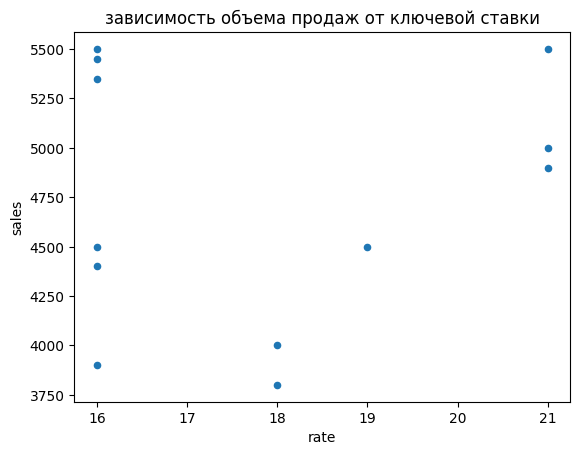

In [15]:
df_itog.plot(kind = 'scatter', y = 'sales', x = 'rate', title='зависимость объема продаж от ключевой ставки') # как взаимозависимость выглядит графически

# Вывод : Зависимость объема продаж от максимальной ключевой ставки банка россии в соответствующем месяце  - отсутствует.

